<a href="https://colab.research.google.com/github/wvirany/microbiome/blob/main/Virany_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning to Predict Microbiome-Phenotype Associations in the Human Gut

---

> ## Walter Virany

The human microbiome is a data rich ecosystem which is generally known to have strong associations with host phenotypes (i.e., the set of observable characteristics of an organism). However, the extents of these relationships are not yet deeply understood. Until recently, the computing capabilities necessary to thoroughly analyze human microbiome data were severely lacking, but due to novel advancements in sequencing technologies and data analysis techniques, there now exist a plethora of data, along with robust statistical tools, which can be leveraged to gain valuable insights into the impact of the human microbiome on overall health. Methods which can accurately detect disease early in developmental stages have the potential to revolutionize personalized and preventative medicine. In this project, I explore state-of-the-art machine learning methods for processing human microbiome data, which I then use to predict the likelihood of someone devloping IBD. I also perform feature selection to identify which biomarkers are most likely to contribute to the condition. I find that IBD can be attributed to approximately 15-20 different species of bacteria found in the human gut.

In [583]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_auc_score, f1_score, precision_score
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

---
## Data Loading and Preprocessing

The data I will be analyzing was taken as a part of the Integrative Human Microbiome Project$^1$ (HMP2), which includes 1627 stool samples from medical patients. Each patient was classified with IBD or as a control (i.e., healthy), which is the target variable. The features are the relative species abundances found in each stool sample. This is the proportion of each species recorded in the sample with respect to the others. First, I access the data from `curatedMetagenomicData()`$^2$, a package within R's Bioconductor library. The R script which fetches the data and writes it to a csv is shown:

```R
library(curatedMetagenomicData)
library(curatedMetagenomicAnalyses)
library(dplyr)

healthy_hmp <- sampleMetadata |>
  filter(study_name == "HMP_2019_ibdmdb") |>
  filter(disease == "healthy") |>
  select(where(~ !any(is.na(.x)))) |>
  returnSamples("relative_abundance", rownames="short", counts=TRUE)

ibd_hmp <- sampleMetadata |>
  filter(study_name == "HMP_2019_ibdmdb") |>
  filter(disease == "IBD") |>
  select(where(~ !any(is.na(.x)))) |>
  returnSamples("relative_abundance", rownames="short", counts=TRUE)

ibd <- t(ibd_hmp@assays@data@listData[["relative_abundance"]])

healthy <- t(healthy_hmp@assays@data@listData[["relative_abundance"]])

write.csv(ibd, "~/Code/R/curatedMetagenomicData/ibd_rel_abundance.csv", row.names=FALSE)

write.csv(healthy, "~/Code/R/curatedMetagenomicData/healthy_rel_abundance.csv", row.names=FALSE)
```

Next, I load the data as a pandas dataframe, explore the structure of the data, and perform some transformations.

In [584]:
ibd = pd.read_csv("ibd_rel_abundance.csv")
healthy = pd.read_csv("healthy_rel_abundance.csv")

In [585]:
print(ibd.shape)
ibd.head()

(1201, 579)


,Phocaeicola vulgatus,Bacteroides uniformis,Bacteroides thetaiotaomicron,Faecalibacterium prausnitzii,Roseburia faecis,Bacteroides caccae,Enterocloster clostridioformis,Bacteroides fragilis,Fusicatenibacter saccharivorans,Flavonifractor plautii,...,Prevotella histicola,Prevotella pallens,Chlamydia ibidis,Enterococcus mundtii,Anaerostipes sp. 992a,Actinobaculum sp. oral taxon 183,Lachnoclostridium sp. An298,Haemophilus haemolyticus,Enterococcus dispar,Atopobium minutum
0,8436640,6235541,1357098,1054351,999360,551484,334448,168192,139201,133264,...,0,0,0,0,0,0,0,0,0,0
1,17080974,9468596,2861845,189087,190713,479440,315591,182143,268493,427323,...,0,0,0,0,0,0,0,0,0,0
2,12088033,14919763,7543241,452106,455094,1991901,537137,7969977,5346,185637,...,0,0,0,0,0,0,0,0,0,0
3,9174317,15253970,4019070,988736,429513,964149,46820,3271311,37552,86170,...,0,0,0,0,0,0,0,0,0,0
4,3662205,8560295,7882055,817546,814911,686063,27640,4984518,9446,411733,...,0,0,0,0,0,0,0,0,0,0


In [586]:
print(healthy.shape)
healthy.head()

(426, 579)


,Phocaeicola vulgatus,Bacteroides uniformis,Bacteroides thetaiotaomicron,Faecalibacterium prausnitzii,Roseburia faecis,Bacteroides caccae,Enterocloster clostridioformis,Bacteroides fragilis,Fusicatenibacter saccharivorans,Flavonifractor plautii,...,Prevotella histicola,Prevotella pallens,Chlamydia ibidis,Enterococcus mundtii,Anaerostipes sp. 992a,Actinobaculum sp. oral taxon 183,Lachnoclostridium sp. An298,Haemophilus haemolyticus,Enterococcus dispar,Atopobium minutum
0,3533802,0,1337816,687547,53255,715021,0,372727,65730,0,...,0,0,0,0,0,0,0,0,0,0
1,6064315,0,3210841,1360390,170153,988210,0,556607,6110,0,...,0,0,0,0,0,0,0,0,0,0
2,8981714,417246,2959316,3261926,428559,2618916,0,378112,43182,3868,...,0,0,0,0,0,0,0,0,0,0
3,4846186,668638,127925,1308172,247559,445041,0,0,85596,77852,...,0,0,0,0,0,0,0,0,0,0
4,3127461,0,1190156,1030098,126186,804786,0,135517,47591,0,...,0,0,0,0,0,0,0,0,0,0


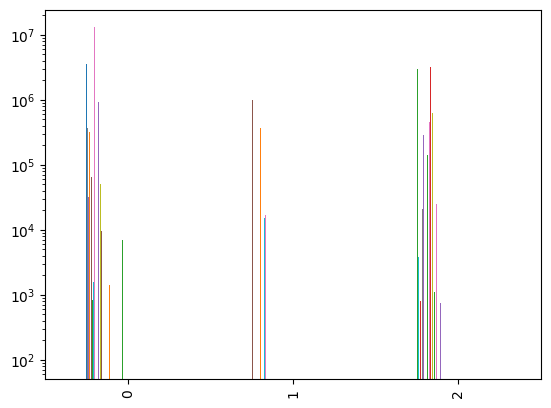

In [587]:
# Histogram of the first 3 elements of the healthy dataframe
healthy[:3].plot(kind='bar', legend=False, logy=True);

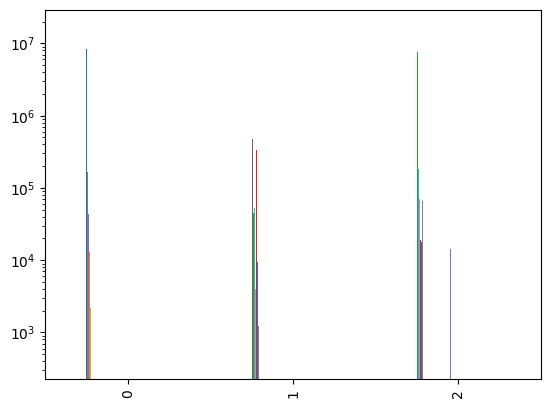

In [588]:
# Histogram of the first 3 elements of the IBD dataframe
ibd[:3].plot(kind='bar', legend=False, logy=True);

It seems like in each of the datasets certain columns significantly outweight others. So, I normalize the columns by dividing each by its maximum value.

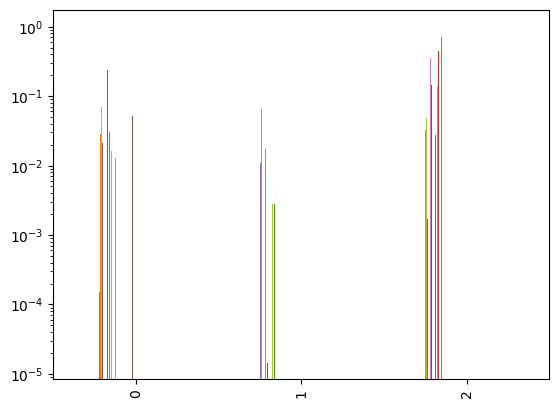

In [589]:
# Copying original dataframe
healthy_normalized = healthy.copy()

# Dividing each column by its maximum value
for column in healthy.columns:
    healthy_normalized[column] = healthy_normalized[column]  / healthy[column].abs().max()

# Plotting first 5 entries of normalized dataframe
healthy_normalized[:3].plot(kind='bar', legend=False, logy=True);

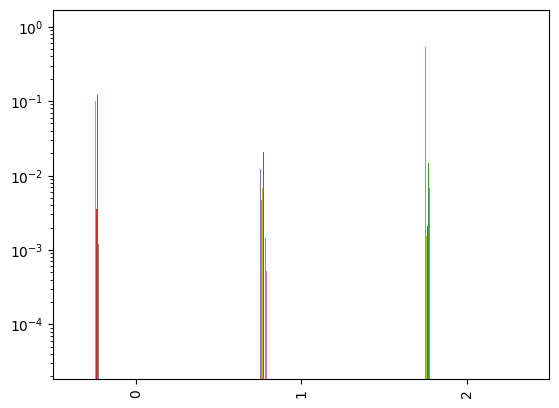

In [590]:
# Copying original dataframe
ibd_normalized = ibd.copy()

# Dividing each column by its maximum value
for column in ibd.columns:
    ibd_normalized[column] = ibd_normalized[column]  / ibd[column].abs().max()

# Plotting first 5 entries of normalized dataframe
ibd_normalized[:3].plot(kind='bar', legend=False, logy=True);

This is unlabeled data, so my next step is to insert target columns into each of the dataframes.

In [ ]:
healthy_normalized.insert(0, 'IBD', 0); # 0 for control sample
ibd_normalized.insert(0, 'IBD', 1); # 1 for case sample

In [592]:
healthy_normalized.head()

,IBD,Phocaeicola vulgatus,Bacteroides uniformis,Bacteroides thetaiotaomicron,Faecalibacterium prausnitzii,Roseburia faecis,Bacteroides caccae,Enterocloster clostridioformis,Bacteroides fragilis,Fusicatenibacter saccharivorans,...,Prevotella histicola,Prevotella pallens,Chlamydia ibidis,Enterococcus mundtii,Anaerostipes sp. 992a,Actinobaculum sp. oral taxon 183,Lachnoclostridium sp. An298,Haemophilus haemolyticus,Enterococcus dispar,Atopobium minutum
0,0,0.145263,0.000000,0.223903,0.046683,0.003363,0.076529,0.0,0.019606,0.073251,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
1,0,0.249284,0.000000,0.537380,0.092369,0.010744,0.105768,0.0,0.029279,0.006809,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
2,0,0.369208,0.032873,0.495284,0.221480,0.027061,0.280303,0.0,0.019889,0.048123,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
3,0,0.199211,0.052680,0.021410,0.088823,0.015632,0.047633,0.0,0.000000,0.095390,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
4,0,0.128560,0.000000,0.199190,0.069942,0.007968,0.086136,0.0,0.007128,0.053036,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


Now, to build my complete dataset, I concatenate the two dataframes and shuffle them. Then, I reindex the resulting dataframe.

In [593]:
data = pd.concat([ibd_normalized, healthy_normalized]).sample(frac=1).set_index(np.arange(0, 1627))

X = data.drop('IBD', axis=1).fillna(0) # Features
y = data['IBD'] # Targets

---

## Feature Selection: Applying Lasso and ENet to Optimize Support Vector Machine



The resulting dataset is a sparse matrix of relative species abundance, with a large amount of features. My next goal is to see how each model performs on different subsets of the features. In the long run, this will help me make biological insights as to which species are most commonly linked to IBD. First, I implement a base SVM estimator to test whether or not there is a relationship between the features and the target variable. I do this by implementing `GridSearchCV()`, which performs a 5-fold stratified cross-validation over a given parameter space for the SVM. A radial kernel is used, and the regularization parameter $C$ and width parameter $\gamma$ were chosen from the sets $\{2^{-5}, 2^{-4}, \dots, 2^{15}\}$, and $\{2^{-15}, 2^{-14}, \dots, 2^3\}$, respectively. This was a costly process on the full data set, so the code is commented out here. The optimal parameters were determined to be:

$$
C = 2048, \\
\gamma = .5
$$

In [594]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [595]:
# svm_params = {'C': [2.0**(x) for x in np.arange(-5, 16)],
#                 'gamma': [2.0**(x) for x in np.arange(-15, 4)],
#                 'kernel': ['rbf']}

# svm_base = GridSearchCV(SVC(), svm_params, refit=False, cv=5, verbose=0).fit(X_train, y_train)

In [596]:
svm_base = SVC(C=2048, gamma=.5, kernel='rbf').fit(X_train, y_train)

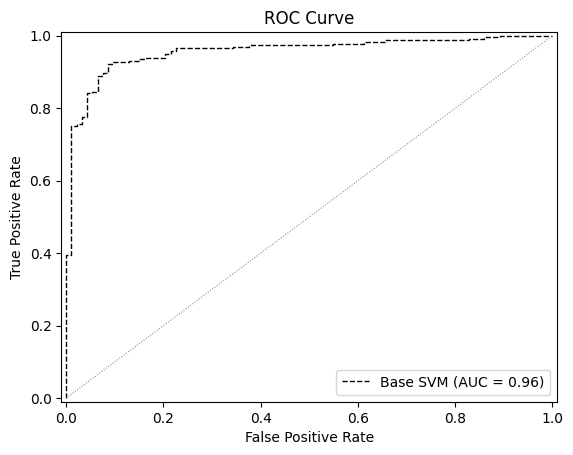

In [597]:
fig_params = {'estimator' : svm_base,
              'name' : 'Base SVM',
              'X' : X_test,
              'y' : y_test,
              'c' : 'black',
              'ls' : 'dashed',
              'lw' : 1}

ax = RocCurveDisplay.from_estimator(**fig_params).ax_
ax.plot([0,1], c='gray', ls='dotted', lw=.75)

ax.set_xlim(-.01, 1.01)
ax.set_ylim(-.01, 1.01)

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

plt.show();

This figure shows the ROC curve for the base SVM estimator. Now, I want to perform feature selection on the dataset and see how the model performs on various subsets of the original features. So, I implement two different feature selection methods; Lasso and Elastic Net Regularization. Then, I assess each model's accuracy on different subsets of the features.

First, I implement `LassoCV()`, which searches for the optimal alpha parameter in $\{10^{-4}, 10^{-3.5}, \dots, 10^{.5}\}$, as described in Pasolli et al.$^3$

In [598]:
alphas = [10**(x) for x in np.arange(-4, 0, step=.5)]

lassoCV = LassoCV(cv = 5,
                alphas=alphas,
                random_state=42).fit(X, y)

Similarly, I implement `ENetCV()`, which searches for the optimal `alpha` parameter as before, as well as the optimal `l1 ratio` parameter in $\{.1, .5, .7, .9, .95, .99, 1\}$.

In [599]:
l1_ratios = [.1, .5, .7, .9, .95, .99, 1]

enetCV = ElasticNetCV(l1_ratio=l1_ratios,
                      alphas=alphas,
                      cv=5,
                      random_state=1984).fit(X, y)

Interestingly, ENetCV returned an L1 ration of .1, which leans more towards an L$^2$ norm for feature selection.

Then, I remove all of the columns in which the lasso coefficient is zero.

In [600]:
X_lasso = X.copy()

while(int(np.min(np.abs(lassoCV.coef_)) == 0)):
  idx = np.argmin(np.abs(lassoCV.coef_))
  X_lasso = X_lasso.drop(X_lasso.columns[idx], axis=1)
  lassoCV.coef_ = np.delete(lassoCV.coef_, idx)

For ENet, I simply keep the same amount of features that were returned by Lasso, since I expect to select a smaller subset of the features soon anyway.

In [601]:
X_enet = X.copy()

for i in range(407):
  idx = np.argmin(np.abs(enetCV.coef_))
  X_enet = X_enet.drop(X_enet.columns[idx], axis=1)
  enetCV.coef_ = np.delete(enetCV.coef_, idx)

Now, we have two subsets of the original features; `X_lasso` and `X_enet`, each with the 172 "most important" features as determined by each of the corresponding regularization algorithms.

In [602]:
print(set(X_lasso.columns) == set(X_enet.columns))

False


Not surprisingly, each method returned a different subset of the features, so there might be some interesting insights to explore regarding which features are truly important.

I want to determine which features to include in my model, so I will train/test the model while varying the percentage of features included in the process:

In [603]:
percentiles = [.1 * x for x in np.arange(0, 10)]

total_coefs = lassoCV.coef_.size
svm_score_W, svm_score_V = np.zeros(10), np.zeros(10)


for q, p in enumerate(percentiles):

  W, V = X_lasso.copy(), X_enet.copy()

  W_DF, V_DF = pd.DataFrame(), pd.DataFrame()

  coefs_W, coefs_V = [], []


  lasso_coefs, enet_coefs = lassoCV.coef_, enetCV.coef_

  # Contructing the dataset with top p percent of features included:

  for i in range(int((1-p) * total_coefs)):

    idx_W = np.argmax(np.abs(lasso_coefs))
    idx_V = np.argmax(np.abs(enet_coefs))

    coefs_W.append(np.max(np.abs(lasso_coefs)))
    coefs_V.append(np.max(np.abs(enet_coefs)))

    W_DF = pd.concat([W_DF, W[W.columns[idx_W]]], axis=1)
    V_DF = pd.concat([V_DF, V[V.columns[idx_W]]], axis=1)

    lasso_coefs = np.delete(lasso_coefs, idx_W)
    W = W.drop(W.columns[idx_W], axis=1)

    enet_coefs = np.delete(enet_coefs, idx_V)
    V = V.drop(V.columns[idx_V], axis=1)

  # Training / testing and averaging results:

  for i in range(20):

    W_train, W_test, y_train_W, y_test_W = train_test_split(W_DF, y, test_size=.2, random_state=42)
    V_train, V_test, y_train_V, y_test_V = train_test_split(V_DF, y, test_size=.2, random_state=42)


    svm_W = SVC(C=2048, gamma=.5, kernel='rbf').fit(W_train, y_train_W)
    svm_V = SVC(C=2048, gamma=.5, kernel='rbf').fit(V_train, y_train_V)

    svm_score_W[q] += (svm_W.score(W_test, y_test_W) / 20)
    svm_score_V[q] += (svm_V.score(V_test, y_test_V) / 20)

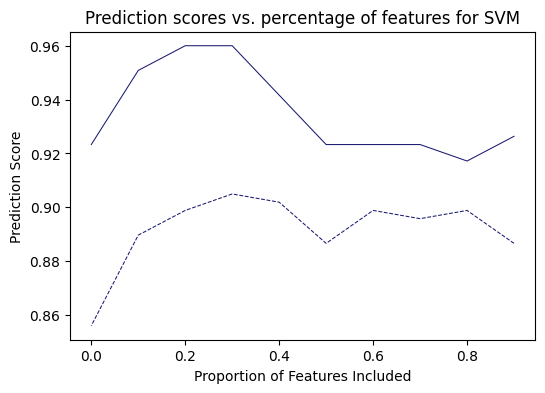

In [604]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(percentiles[::-1], svm_score_W, label='Lasso Features', c='midnightblue', lw=.75)
ax.plot(percentiles[::-1], svm_score_V, label='ENet Features', ls='dashed', c='midnightblue', lw=.75)
ax.set_xlabel('Proportion of Features Included')
ax.set_ylabel('Prediction Score')
ax.set_title('Prediction scores vs. percentage of features for SVM');

It seems like the model with features chosen by Lasso consistently outperforms the one with features chosen by ENet. Furthermore, even with just 10% of the most important features included, the Lasso model still performs well. So, from this point forward I will use the Lasso model.

Now, I construct the dataset with the top 10% of features as determined by Lasso.

In [605]:
for i in range(155):

  idx = np.argmin(np.abs(lassoCV.coef_))
  X_lasso = X_lasso.drop(X_lasso.columns[idx], axis=1)
  lassoCV.coef_ = np.delete(lassoCV.coef_, idx)

X_lasso_train, X_lasso_test, y_lasso_train, y_lasso_test = train_test_split(X_lasso, y, test_size=.2, random_state=1984)

In [606]:
coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, random_state=42)
    lasso.fit(X_lasso_train, y_lasso_train)
    coefs.append(lasso.coef_)

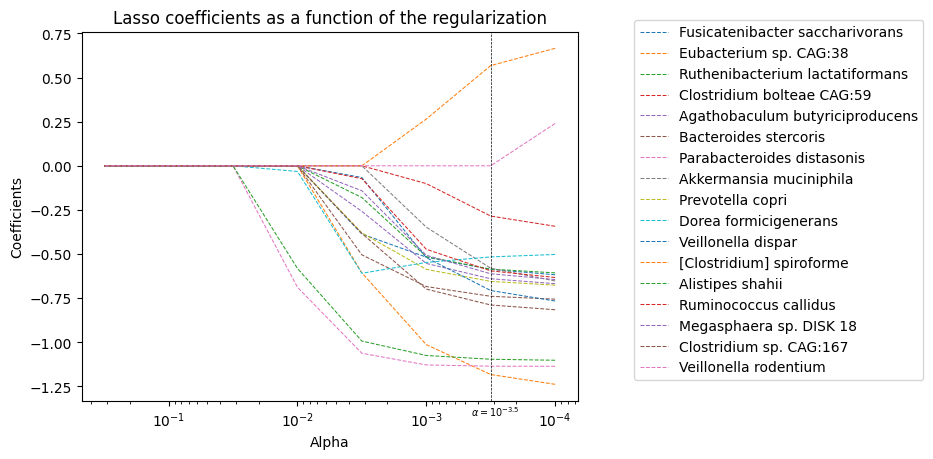

In [607]:
fig = plt.figure()
ax = plt.subplot(111)
trans = ax.get_xaxis_transform()

ax.plot(alphas, coefs, ls='dashed', lw=.75)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axvline(lassoCV.alpha_, lw=.5, ls='dashed', c='black')
plt.text(x=10**-3.35, y=-.04, s='$\\alpha = 10^{-3.5}$', fontsize='x-small', transform=trans)
plt.xlabel("Alpha")
plt.ylabel("Coefficients")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
ax.legend(X_lasso.columns, bbox_to_anchor=(1.1, 1.05))
plt.show()

This figure demonstrates how the Lasso coefficients change as a function of the regularization parameter. The legend indicates the names of the features included in the model, which are bacterial species found in the gut microbiome. The optimal regularization parameter that is chosen by `LassoCV()` is shown as a vertical line at $\alpha = 10^{-3.5}$.

In [608]:
svm_lasso = SVC(C=2048, gamma=.5, kernel='rbf').fit(X_lasso_train, y_lasso_train)

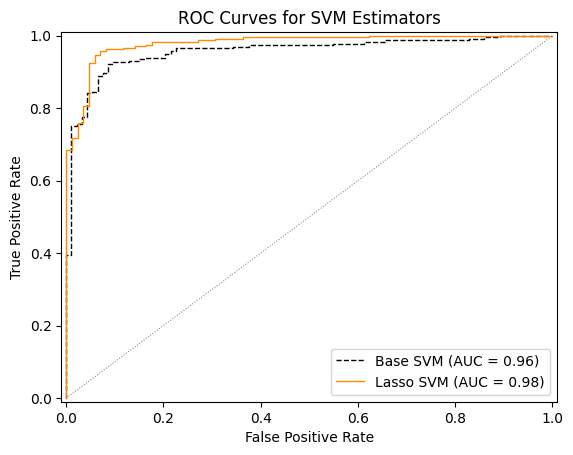

In [609]:
ax = plt.gca()

fig_params1 = {'estimator':svm_base,
              'name':'Base SVM',
              'X': X_test,
              'y': y_test,
              'ax' : ax,
              'c': 'black',
              'ls': 'dashed',
              'lw': 1}

fig_params2 = {'estimator' : svm_lasso,
              'name' : 'Lasso SVM',
              'X' : X_lasso_test,
              'y' : y_lasso_test,
              'ax' : ax,
              'c' : 'darkorange',
              'ls' : 'solid',
              'lw' : 1}

RocCurveDisplay.from_estimator(**fig_params1)
RocCurveDisplay.from_estimator(**fig_params2)
ax.plot([0,1], c='gray', ls='dotted', lw=.75)

ax.set_xlim(-.01, 1.01)
ax.set_ylim(-.01, 1.01)

ax.set_title('ROC Curves for SVM Estimators')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

plt.show();

---

## Random Forests

The next step is to construct a random forest and compare its accuracy to the SVM. The process for constructing the RF is outlined in [3], which I reiterate here:

* The parameters are chosen as
  * Number of trees: 500
  * Criterion: Gini impurity
  * Number of features considered at each split: $m = \sqrt{p}$, where $p$ is the total number of predictors
  * `class_weight = balanced`, to account for the imabalance between # of case samples vs. controls (i.e., there are more patients with IBD in the dataset than healthy patients)
* `GridSearchCV()` is performed in an attempt to achieve more optimal paramters; however, no significant improvement was made, so the original paramters were kept
* An implicit feature selection is performed using the impurity-based feature importance. The steps for this process are:
  1. The RF is trained on the whole dataset
  2. The features were ranked according to the impurity-based importance
  3. The RF is retrained on the top $k$ features, where $k$ is chosen from $\{5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200\}$
  4. The number of features that maximizes the accuracy is chosen
  5. The final model is retrained on this subset of features


In [610]:
# No significant difference when optimizing hyperparameters with grid search:

# rf_params = {'n_estimators': [50, 75, 100, 150, 200, 300, 400, 500],
#              'criterion': ['gini', 'entropy', 'log_loss'],
#              'max_features': ['sqrt', 'log2', None],
#              'class_weight': ['balanced', None],
#              'random_state': [1]}

# rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, refit=True, cv=5)

# rf_grid.fit(X_train, y_train)

In [611]:
rf = RandomForestClassifier(n_estimators=500,
                                       criterion='gini',
                                       max_features='sqrt',
                                       class_weight='balanced',
                                       random_state=1984).fit(X_train, y_train)

In [612]:
k = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200]
rf_scores = []

for j in k:

  K = X.copy()

  features = rf.feature_importances_

  # Contrstructing list of top k features by dropping lowest 579 - k features:

  for i in range(579 - j):
    idx = np.argmin(features)
    K = K.drop(K.columns[idx], axis=1)
    features = np.delete(features, idx)

  K_train, K_test, y_k_train, y_k_test = train_test_split(K, y, test_size=.2, random_state=1984)

  rf_temp = RandomForestClassifier(n_estimators=500,
                                   criterion='gini',
                                   max_features='sqrt',
                                   class_weight='balanced',
                                   random_state=1984).fit(K_train, y_k_train)

  rf_scores.append(rf_temp.score(K_test, y_k_test))

k = k[np.argmax(rf_scores)]

In [613]:
print('The k value corresponding to the best score is:', k)

The k value corresponding to the best score is: 80


In [614]:
K = X.copy()

features = rf.feature_importances_

# Contrstructing list of top k features by dropping lowest 579 - k features:

for i in range(579 - k):
  idx = np.argmin(features)
  K = K.drop(K.columns[idx], axis=1)
  features = np.delete(features, idx)

K_train, K_test, y_k_train, y_k_test = train_test_split(K, y, test_size=.2, random_state=1984)

rf = RandomForestClassifier(n_estimators=500,
                                       criterion='gini',
                                       max_features='sqrt',
                                       class_weight='balanced',
                                       random_state=1984).fit(K_train, y_k_train)

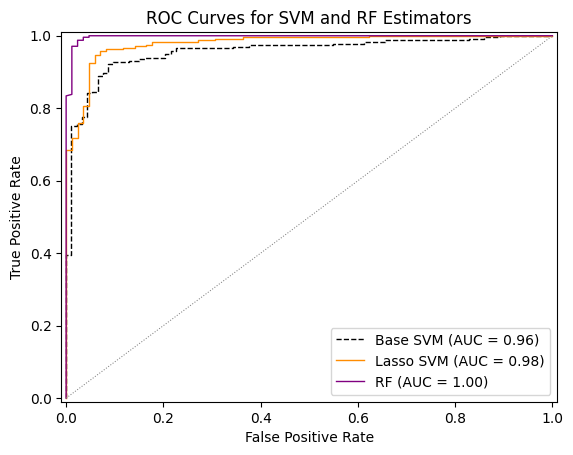

In [615]:
ax = plt.gca()

fig_params1 = {'estimator':svm_base,
              'name':'Base SVM',
              'X': X_test,
              'y': y_test,
              'ax' : ax,
              'c': 'black',
              'ls': 'dashed',
              'lw': 1}

fig_params2 = {'estimator' : svm_lasso,
              'name' : 'Lasso SVM',
              'X' : X_lasso_test,
              'y' : y_lasso_test,
              'ax' : ax,
              'c' : 'darkorange',
              'ls' : 'solid',
              'lw' : 1}

fig_params3 = {'estimator' : rf,
               'name' : 'RF',
               'X' : K_test,
               'y' : y_k_test,
               'ax' : ax,
               'c' : 'purple',
               'ls' : 'solid',
               'lw' : 1}

for i in [fig_params1, fig_params2, fig_params3]:
  RocCurveDisplay.from_estimator(**i)

ax.plot([0,1], c='gray', ls='dotted', lw=.75)

ax.set_xlim(-.01, 1.01)
ax.set_ylim(-.01, 1.01)

ax.set_title('ROC Curves for SVM and RF Estimators')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

plt.show();

The figure above shows the ROC curves for the base SVM, the Lasso SVM, and the RF models. The confusion matrices for each model are also shown:

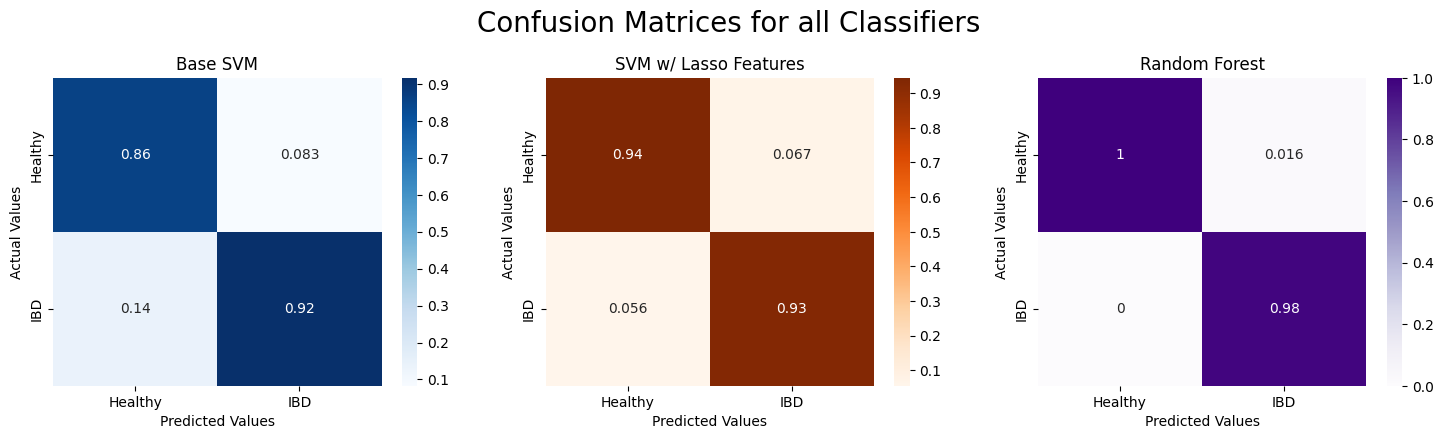

In [616]:
base_pred = svm_base.predict(X_test)
lasso_pred = svm_lasso.predict(X_lasso_test)
rf_pred = rf.predict(K_test)

# Creating a confusion matrix for both linear and radial SVM classifier
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

c = confusion_matrix(y_test, base_pred, normalize='pred')
axes[0] = sns.heatmap(c,
                      annot=True,
                      cmap='Blues',
                      xticklabels=['Healthy', 'IBD'],
                      yticklabels=['Healthy', 'IBD'],
                      cbar=True,
                      ax=axes[0]);

axes[0].set_ylabel('Actual Values')
axes[0].set_xlabel('Predicted Values')
axes[0].set_title('Base SVM');

c = confusion_matrix(y_lasso_test, lasso_pred, normalize='pred')
axes[1] = sns.heatmap(c,
                      annot=True,
                      cmap='Oranges',
                      xticklabels=['Healthy', 'IBD'],
                      yticklabels=['Healthy', 'IBD'],
                      cbar=True,
                      ax=axes[1]);

axes[1].set_ylabel('Actual Values')
axes[1].set_xlabel('Predicted Values')
axes[1].set_title('SVM w/ Lasso Features');

c = confusion_matrix(y_k_test, rf_pred, normalize='pred')
axes[2] = sns.heatmap(c,
                      annot=True,
                      cmap='Purples',
                      xticklabels=['Healthy', 'IBD'],
                      yticklabels=['Healthy', 'IBD'],
                      cbar=True,
                      ax=axes[2]);

axes[2].set_ylabel('Actual Values')
axes[2].set_xlabel('Predicted Values')
axes[2].set_title('Random Forest');

fig.suptitle('Confusion Matrices for all Classifiers', y=1.05, fontsize=20);

Evidently, the RF tends to perform the best. This could be due to interactions between the features, which the RF accounts for by decorrelating the trees. Moreover, the RF accounts for the imbalance between the classes. The IBD class has about 3 times as many samples as the healthy class. There also seems to be a certain amount of variability on each run. So, I run each model 20 times and average the AUC, F1, and precision scores.

In [617]:
svm_base_score = {'AUC' : [0],
                  'F1-Score' : [0],
                  'Precision' : [0]}

svm_lasso_score = {'AUC' : [0],
                  'F1-Score' : [0],
                  'Precision' : [0]}

rf_score = {'AUC' : [0],
            'F1-Score' : [0],
            'Precision' : [0]}

for i in range(20):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1984)
  X_lasso_train, X_lasso_test, y_lasso_train, y_lasso_test = train_test_split(X_lasso, y, test_size=.2, random_state=1984)
  K_train, K_test, y_k_train, y_k_test = train_test_split(K, y, test_size=.2, random_state=1984)

  svm_base = SVC(C=2048, gamma=.5, kernel='rbf').fit(X_train, y_train)

  base_pred = svm_base.predict(X_test)

  svm_base_score['AUC'] += roc_auc_score(y_test, base_pred) / 19
  svm_base_score['F1-Score'] += f1_score(y_test, base_pred) / 20
  svm_base_score['Precision'] += precision_score(y_test, base_pred) / 20


  svm_lasso = SVC(C=2048, gamma=.5, kernel='rbf').fit(X_lasso_train, y_lasso_train)

  lasso_pred = svm_lasso.predict(X_lasso_test)

  svm_lasso_score['AUC'] += roc_auc_score(y_lasso_test, lasso_pred) / 20
  svm_lasso_score['F1-Score'] += f1_score(y_lasso_test, lasso_pred) / 20
  svm_lasso_score['Precision'] += precision_score(y_lasso_test, lasso_pred) / 20

  rf = RandomForestClassifier(n_estimators=500,
                              criterion='gini',
                              max_features='sqrt',
                              class_weight='balanced',
                              random_state=1984).fit(K_train, y_k_train)

  rf_pred = rf.predict(K_test)

  rf_score['AUC'] += roc_auc_score(y_k_test, rf_pred) / 20
  rf_score['F1-Score'] += f1_score(y_k_test, rf_pred) / 20
  rf_score['Precision'] += precision_score(y_k_test, rf_pred) / 20

In [618]:
df1 = pd.DataFrame(svm_base_score, index=['SVM Base Metrics'])
df2 = pd.DataFrame(svm_lasso_score, index=['SVM Lasso Metrics'])
df3 = pd.DataFrame(rf_score, index=['RF Metrics'])

df = pd.concat([df1, df2, df3]).round(3)

In [619]:
df

,AUC,F1-Score,Precision
SVM Base Metrics,0.948,0.950,0.947
SVM Lasso Metrics,0.892,0.958,0.933
RF Metrics,0.976,0.992,0.984



---


## Discussion

Overall, the random forest model tends to perform the best across all metrics. This could be due to a number of reasons; the foremost being the class imbalance between healthy patients and those with IBD, as well as the correlation between features. The RF is robust to both of these scenarios. Furthermore, it is found that IBD can be predicted from a subset of only 15-20 different species. It is also interesting to note that IBD is generally linked to a deficiency in biodiversity in the human digestive tract. Looking at the histograms of the unprocessed data (Figures 1-4), we see that there generally tends to be less diversity in the IBD sampels as opposed to the healthy samples. This is consistent with our biological knowledge. It is also interesting to note that certain features identified here have also been linked in other studies to healthy vs. unhealthy eating habits [4].



---


## Next Steps

For future steps in the project, I would like to explore a number of ideas:



* Perform cross-validation of results across different studies
* Generalize results to larger datasets
* Perform analysis on different diseases
* Explore different models for classification
  * One publication describes a comprehensive analysis of deep learning methods for similar tasks
  * Another study attempts to use convolutional neural networks by embedding information about relative species abundance in 2D images
  
Evidently, there are a lot of interesting avenues to explore from here.



## References

  1. Lloyd-Price, J., Arze, C., Ananthakrishnan, A.N. et al. Multi-omics of the gut microbial ecosystem in inflammatory bowel diseases. Nature 569, 655–662 (2019). doi.org/10.1038/s41586-019-1237-9.

  2. Pasolli E, Schiffer L, Manghi P, Renson A, Obenchain V, Truong D,
  Beghini F, Malik F, Ramos M, Dowd J, Huttenhower C, Morgan M, Segata N, Waldron L (2017). “Accessible, curated metagenomic data through ExperimentHub.” Nat. Methods, 14(11), 1023–1024. ISSN 1548-7091, 1548-7105, doi:10.1038/nmeth.4468.

  3. Pasolli E, Truong DT, Malik F, Waldron L,
  Segata N (2016) Machine Learning Meta-analysis of
  Large Metagenomic Datasets: Tools and Biological
  Insights. PLoS Comput Biol 12(7): e1004977.
  doi:10.1371/journal.pcbi.1004977

  4. Medawar, E., Haange, SB., Rolle-Kampczyk, U. et al. Gut microbiota link dietary fiber intake and short-chain fatty acid metabolism with eating behavior. Transl Psychiatry 11, 500 (2021). doi.org/10.1038/s41398-021-01620-3

  5. LaPierre, Nathan, et al. ‘MetaPheno: A Critical Evaluation of Deep Learning and Machine Learning in Metagenome-Based Disease Prediction’. Methods, vol. 166, 2019, pp. 74–82, https://doi.org10.1016/j.ymeth.2019.03.003.

  6. Nguyen, Thanh Hai, et al. ‘Disease Classification in Metagenomics with 2D Embeddings and Deep Learning’. arXiv [Cs.CV], 2018, http://arxiv.org/abs/1806.09046. arXiv.